In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-03-20 23:09:22.981338: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
4445,189655,714748
1149,5959,582511
4930,521183,1125992
1827,12238,101263
4348,162080,1135345


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [6]:
print(papers.sample(5).T)

                         219                     650              198   \
paper_id                41714                   81350          1114605   
term_0                      0                       0                0   
term_1                      0                       0                0   
term_2                      0                       0                0   
term_3                      0                       0                0   
...                       ...                     ...              ...   
term_1429                   0                       0                0   
term_1430                   0                       0                0   
term_1431                   0                       0                0   
term_1432                   0                       0                0   
subject    Genetic_Algorithms  Reinforcement_Learning  Neural_Networks   

              2145             1923  
paper_id   1116181           395547  
term_0           0                0

In [7]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [8]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

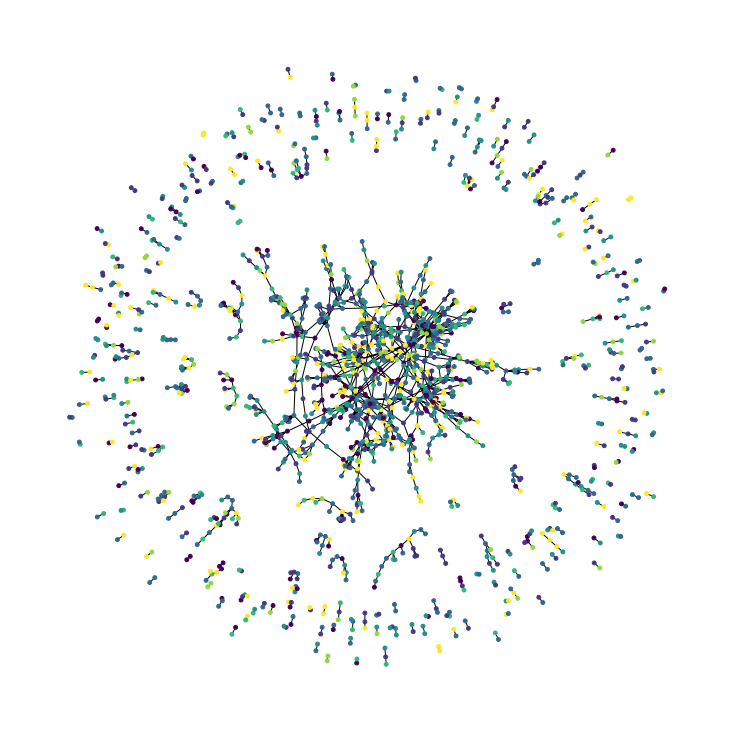

In [9]:
import scipy.sparse
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [10]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1307, 1435)
Test data shape: (1401, 1435)


In [11]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [12]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [13]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [17]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu))

    return keras.Sequential(fnn_layers, name=name)


In [32]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

/tmp/ipykernel_16081/3641831727.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
/tmp/ipykernel_16081/3641831727.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


In [19]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

2022-03-20 23:11:41.842025: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-20 23:11:41.883899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-20 23:11:41.884460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-20 23:11:41.884514: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-20 23:11:41.886646: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [20]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300


2022-03-20 23:12:09.081225: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


5/5 [==============================] - 0s 68ms/step - loss: 4.5607 - acc: 0.1910 - val_loss: 1.9474 - val_acc: 0.1218
Epoch 2/300
5/5 [==============================] - 0s 18ms/step - loss: 2.9598 - acc: 0.2198 - val_loss: 2.0035 - val_acc: 0.1472
Epoch 3/300
5/5 [==============================] - 0s 16ms/step - loss: 2.4778 - acc: 0.1991 - val_loss: 1.9548 - val_acc: 0.1472
Epoch 4/300
5/5 [==============================] - 0s 18ms/step - loss: 2.2311 - acc: 0.2550 - val_loss: 1.9091 - val_acc: 0.2284
Epoch 5/300
5/5 [==============================] - 0s 20ms/step - loss: 2.0863 - acc: 0.2559 - val_loss: 1.9114 - val_acc: 0.2944
Epoch 6/300
5/5 [==============================] - 0s 18ms/step - loss: 2.0349 - acc: 0.2568 - val_loss: 1.9119 - val_acc: 0.1980
Epoch 7/300
5/5 [==============================] - 0s 18ms/step - loss: 1.9619 - acc: 0.2712 - val_loss: 1.8990 - val_acc: 0.1980
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 1.8664 - acc: 0.3081 - val_los

Epoch 64/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4508 - acc: 0.8586 - val_loss: 0.9883 - val_acc: 0.6751
Epoch 65/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4345 - acc: 0.8613 - val_loss: 0.9925 - val_acc: 0.6802
Epoch 66/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4485 - acc: 0.8523 - val_loss: 0.9551 - val_acc: 0.6904
Epoch 67/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4930 - acc: 0.8234 - val_loss: 0.9851 - val_acc: 0.6954
Epoch 68/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4831 - acc: 0.8360 - val_loss: 1.0445 - val_acc: 0.6650
Epoch 69/300
5/5 [==============================] - 0s 17ms/step - loss: 0.4896 - acc: 0.8234 - val_loss: 1.0773 - val_acc: 0.6650
Epoch 70/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5033 - acc: 0.8234 - val_loss: 1.0516 - val_acc: 0.6599
Epoch 71/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4793 - a

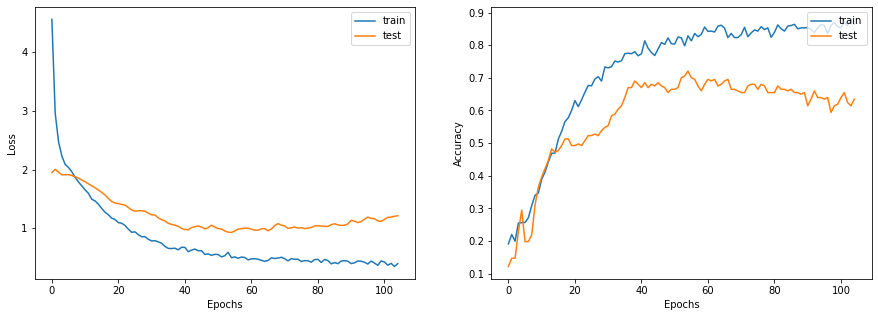

In [21]:
display_learning_curves(history)

In [22]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 76.3%


In [23]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [24]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 1.5%
- Genetic_Algorithms: 2.37%
- Neural_Networks: 6.08%
- Probabilistic_Methods: 73.6%
- Reinforcement_Learning: 2.51%
- Rule_Learning: 6.0%
- Theory: 7.94%
Instance 2:
- Case_Based: 0.62%
- Genetic_Algorithms: 1.23%
- Neural_Networks: 3.07%
- Probabilistic_Methods: 54.94%
- Reinforcement_Learning: 2.52%
- Rule_Learning: 14.8%
- Theory: 22.82%
Instance 3:
- Case_Based: 1.32%
- Genetic_Algorithms: 70.55%
- Neural_Networks: 3.36%
- Probabilistic_Methods: 4.27%
- Reinforcement_Learning: 13.86%
- Rule_Learning: 2.99%
- Theory: 3.65%
Instance 4:
- Case_Based: 0.78%
- Genetic_Algorithms: 0.39%
- Neural_Networks: 90.8%
- Probabilistic_Methods: 6.81%
- Reinforcement_Learning: 0.44%
- Rule_Learning: 0.12%
- Theory: 0.66%
Instance 5:
- Case_Based: 22.87%
- Genetic_Algorithms: 32.72%
- Neural_Networks: 14.71%
- Probabilistic_Methods: 3.21%
- Reinforcement_Learning: 11.16%
- Rule_Learning: 9.59%
- Theory: 5.73%
Instance 6:
- Case_Based: 21.46%
- Genetic_Algorithms: 7.85

In [25]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


/tmp/ipykernel_16081/2468639763.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32


In [26]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [27]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [28]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.21828055  0.08740118  0.04137533  0.14697267 -0.2339125   0.20805945
   0.18503365]
 [ 0.11341789 -0.0007459   0.03420814  0.10994008 -0.30767566  0.25003272
   0.1415737 ]
 [ 0.1896055   0.12204118  0.09895579  0.10746887 -0.27530587  0.08827251
   0.156816  ]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (2708, 32)                52804     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (2708, 32)                2368      
____________________________________________________________

In [33]:
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300


NotImplementedError: in user code:

    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2722 _minimize
        gradients = tape.gradient(loss, trainable_variables)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/eager/backprop.py:1067 gradient
        flat_grad = imperative_grad.imperative_grad(
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/eager/imperative_grad.py:71 imperative_grad
        return pywrap_tfe.TFE_Py_TapeGradient(
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/eager/backprop.py:162 _gradient_function
        return grad_fn(mock_op, *out_grads)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/ops/math_grad.py:470 _UnsortedSegmentSumGrad
        return _GatherDropNegatives(grad, op.inputs[1])[0], None, None
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/ops/math_grad.py:436 _GatherDropNegatives
        array_ops.ones([array_ops.rank(gathered)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:3041 ones
        output = _constant_if_small(one, shape, dtype, name)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2732 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:180 prod
        
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3088 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /opt/miniconda3/envs/gnn/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:845 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (gradient_tape/gnn_model/graph_conv2/sub:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
